In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.insert(0, "..")

from eis_toolkit.exploratory_analyses.pca import compute_pca, plot_pca

/home/niko/.local/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:347: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Sequence[str] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [2]:
# Define filepaths
# NOTE: These files are placed in local and do not come with the repository automatically
AEM_quad_fp = "../tests/data/local/workflow_demo/IOCG_AEM_Quad.tif"
AEM_ratio_fp = "../tests/data/local/workflow_demo/IOCG_EM_ratio.tif"
Magn_AS_fp = "../tests/data/local/workflow_demo/Mag_DGRF_AS_FFT_ers_PCS_tif_clip.tif"
paths = [AEM_quad_fp, AEM_ratio_fp, Magn_AS_fp]

geochem_fp = "../tests/data/local/workflow_demo/Geochemical_Data/Vector_files/IOCG_CLB_Till_Geochem_reg_511p.shp"

PCA with rasters

In [3]:
# Read 3 rasters and stack them into a 3D numpy array for PCA input
raster_data = []
raster_metas = []
for path in paths:
    with rasterio.open(path) as raster:
        data = raster.read(1)  # All are singleband rasters
        data[data==raster.nodata] = np.nan  # Convert nodata to np.nan
        raster_data.append(data)
        raster_metas.append(raster.meta.copy())

raster_data[2] = raster_data[2][1:, :]  # Magnetic data had one more row, just cutting it out to have uniform shapes...

pca_input_array = np.stack(raster_data)
out_meta = raster_metas[0]

print(pca_input_array.shape)

(3, 1641, 1361)


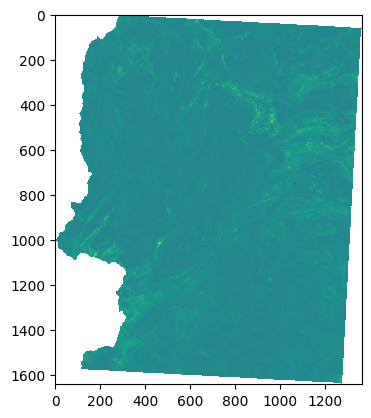

In [4]:
plt.imshow(pca_input_array[0])

In [5]:
out_array, explained_variances = compute_pca(pca_input_array, 3, nodata_handling="remove")
print(explained_variances)
print(out_array.ndim)

[0.40947429 0.36274412 0.22778159]
3


/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/tmp/ipykernel_55301/1619538750.py:14: Runtime

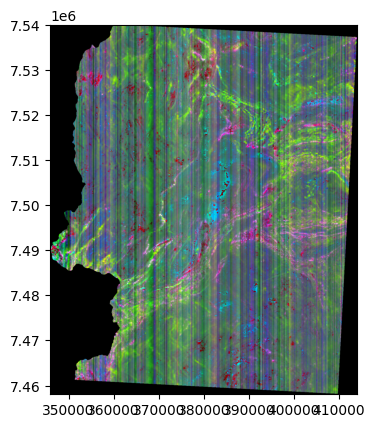

<Axes: >

In [6]:
# Normalize each band to 0-255 and display RGB plot
scaler = MinMaxScaler(feature_range=(0, 255))

# Reshape for scaler and scale each band
scaled_bands = []
for band in range(out_array.shape[0]):
    scaled_band = scaler.fit_transform(out_array[band])
    scaled_bands.append(scaled_band)

# Stack scaled bands back together
scaled_pca_output = np.stack(scaled_bands)

# Display the RGB image
show(scaled_pca_output.astype(np.uint8), transform=out_meta["transform"])

In [7]:
# Save raster to local/results to inspect in QGIS
out_meta["count"] = 3
path = "../tests/data/local/results/pca_test_result.tif"
with rasterio.open(path, "w", **out_meta) as dest:
    dest.write(out_array)

PCA with GDF

/home/niko/.local/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/niko/.local/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/niko/.local/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/niko/.local/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strict

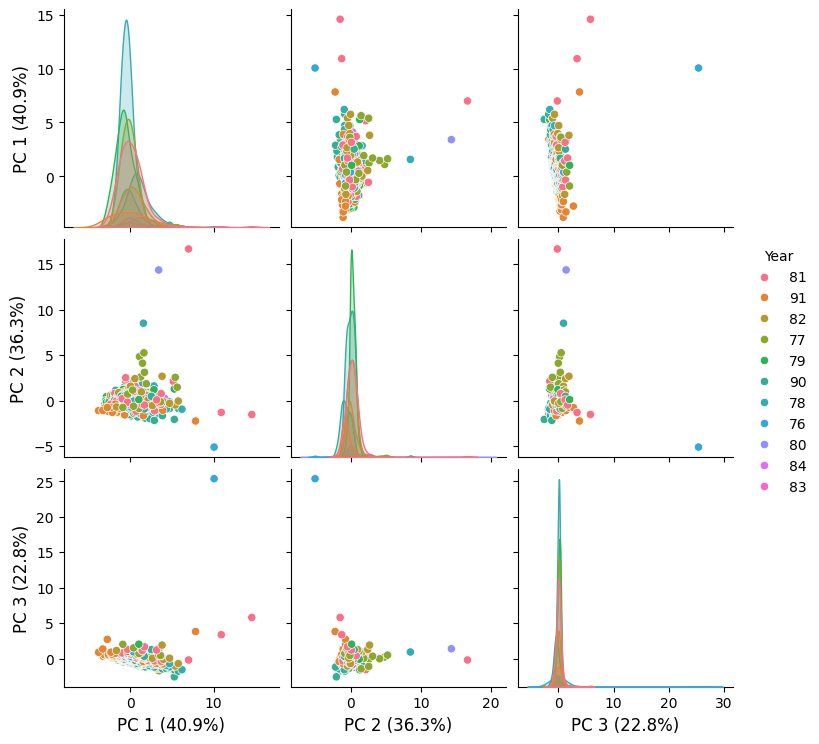

In [8]:
gdf = gpd.read_file(geochem_fp)
result, variances = compute_pca(gdf, number_of_components=3, columns=["Al_ppm_511", "Ba_ppm_511", "Ca_ppm_511", "Li_ppm_511", "Mg_ppm_511"])
plot_pca(result, explained_variances, color_column_name="Year")